In [1]:
import os
import re
import statistics
from src.najdi_rok import najdi_rok
from src.pocet_stran import pocet_stran
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_parquet(os.path.join("data","cnb_vyber.parquet"))
df['rok'] = df['008'].apply(lambda x: najdi_rok(x))
df['pocet_stran'] = df['300_a'].apply(lambda x: pocet_stran(x))

In [3]:
df['pocet_stran'].quantile([0.1,0.25,0.5,0.75,0.9])

0.10     20.0
0.25     52.0
0.50    121.0
0.75    221.0
0.90    335.0
Name: pocet_stran, dtype: float64

In [4]:
nemala = df['pocet_stran'].quantile(0.25)
nemala

52.0

In [5]:
df = df[df['pocet_stran'] >= nemala]

In [6]:
explo041 = df.explode('041_h')
preklady = explo041[(explo041['041_h'].notnull()) & (explo041['041_h'] != 'cze')]

## Podíl překladové literatury (spíš v datech než v realitě)

<Axes: xlabel='rok'>

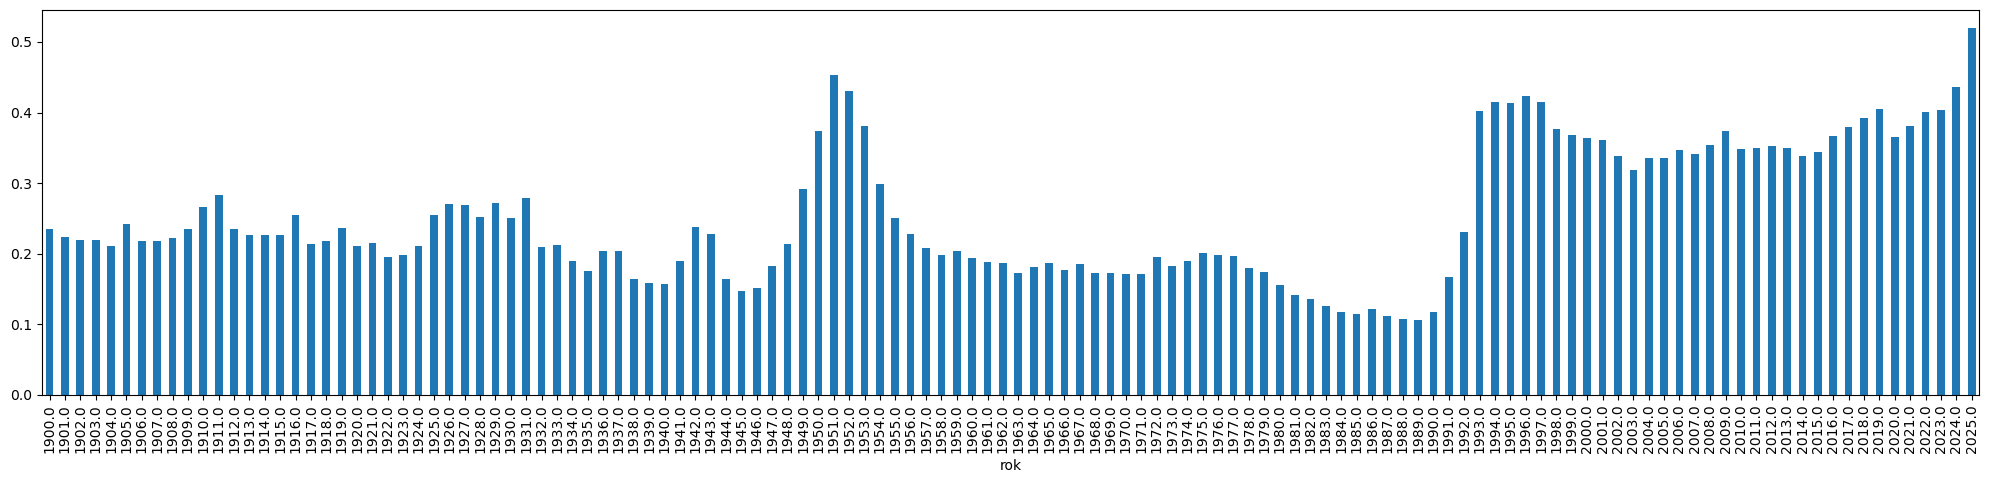

In [8]:
(preklady.groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [9]:
(preklady.groupby('rok').size() / df.groupby('rok').size()).nlargest(20)

rok
2025.0    0.519231
1951.0    0.453011
2024.0    0.436795
1952.0    0.430130
1996.0    0.423223
1994.0    0.415013
1997.0    0.414166
1995.0    0.413232
2019.0    0.404480
2023.0    0.402940
1993.0    0.402677
2022.0    0.401100
2018.0    0.391590
1953.0    0.381312
2021.0    0.380988
2017.0    0.379373
1998.0    0.376339
1950.0    0.373878
2009.0    0.373330
1999.0    0.368808
dtype: float64

<Axes: xlabel='rok'>

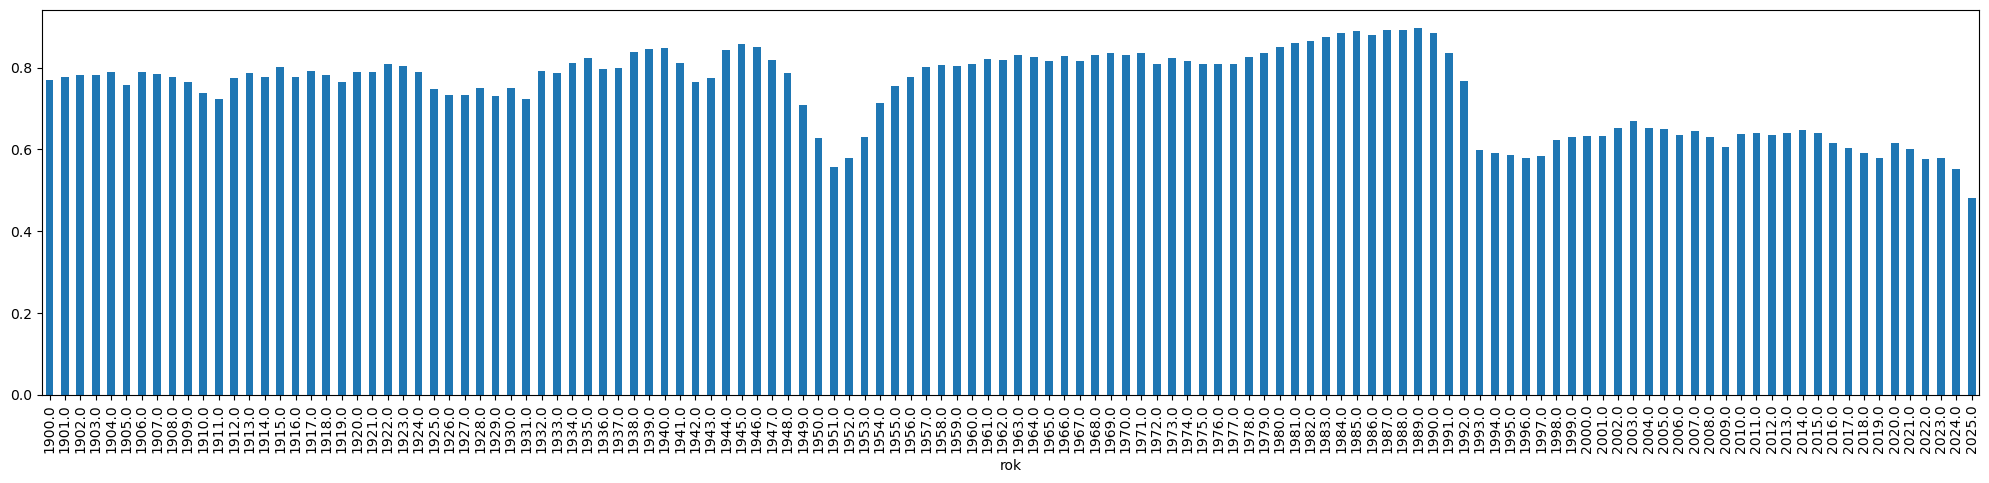

In [10]:
(explo041[explo041['041_h'].isnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [11]:
# (~explo041[explo041['041_h'].isnull() | (~explo041['041_h'] == 'cze')].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

## Top jazyky

In [13]:
preklady.groupby('041_h').size().nlargest(40)

041_h
eng    83654
ger    36458
rus    17541
fre    14827
slo     3954
pol     3787
ita     3619
und     2604
spa     2518
lat     1727
swe     1661
mul     1624
dut     1118
hun     1043
nor      968
grc      894
dan      788
jpn      632
bul      537
chi      499
heb      473
fin      412
sla      383
ukr      375
scr      370
por      347
slv      341
rum      280
gre      172
ice      163
ara      158
arc      156
hrv      151
srp      139
san      120
kor      112
est       91
ben       74
tib       74
lav       73
dtype: int64

In [14]:
jazyky = {'eng': 'angličtina', 'ger': 'němčina', 'rus': 'ruština', 'fre': 'francouzština', 'pol': 'polština', 'ita': 'italština', 'slo': 'slovenština', 'spa': 'španělština', 'lat': 'latina', 'swe': 'švédština', 'dut': 'nizozemština', 'hun': 'madarština', 'nor': 'norština','grc':'řečtina','dan':'dánština','jpn':'japonština','bul':'bulharština','chi':'čínština','heb':'hebrejština','fin':'finština'}

In [15]:
top = preklady.groupby('041_h').size().nlargest(20).index.to_list()
top = [t for t in top if t in jazyky.keys()]
print(len(top))
top

18


['eng',
 'ger',
 'rus',
 'fre',
 'slo',
 'pol',
 'ita',
 'spa',
 'lat',
 'swe',
 'dut',
 'hun',
 'nor',
 'grc',
 'dan',
 'jpn',
 'bul',
 'chi']

In [16]:
preklady.groupby('041_h')['rok'].nunique().nlargest(20)

041_h
eng    126
ger    126
fre    125
ita    125
dan    124
lat    124
rus    124
grc    122
spa    122
pol    121
hun    120
nor    118
swe    118
und    116
dut    110
mul    108
slo    105
slv     99
scr     96
bul     93
Name: rok, dtype: int64

In [17]:
top_serie = []
for t in top:
    top_serie.append(pd.Series( preklady[preklady['041_h'] == t].groupby('rok').size() / preklady.groupby('rok').size(), name=jazyky[t]))

japonština


<Axes: xlabel='rok'>

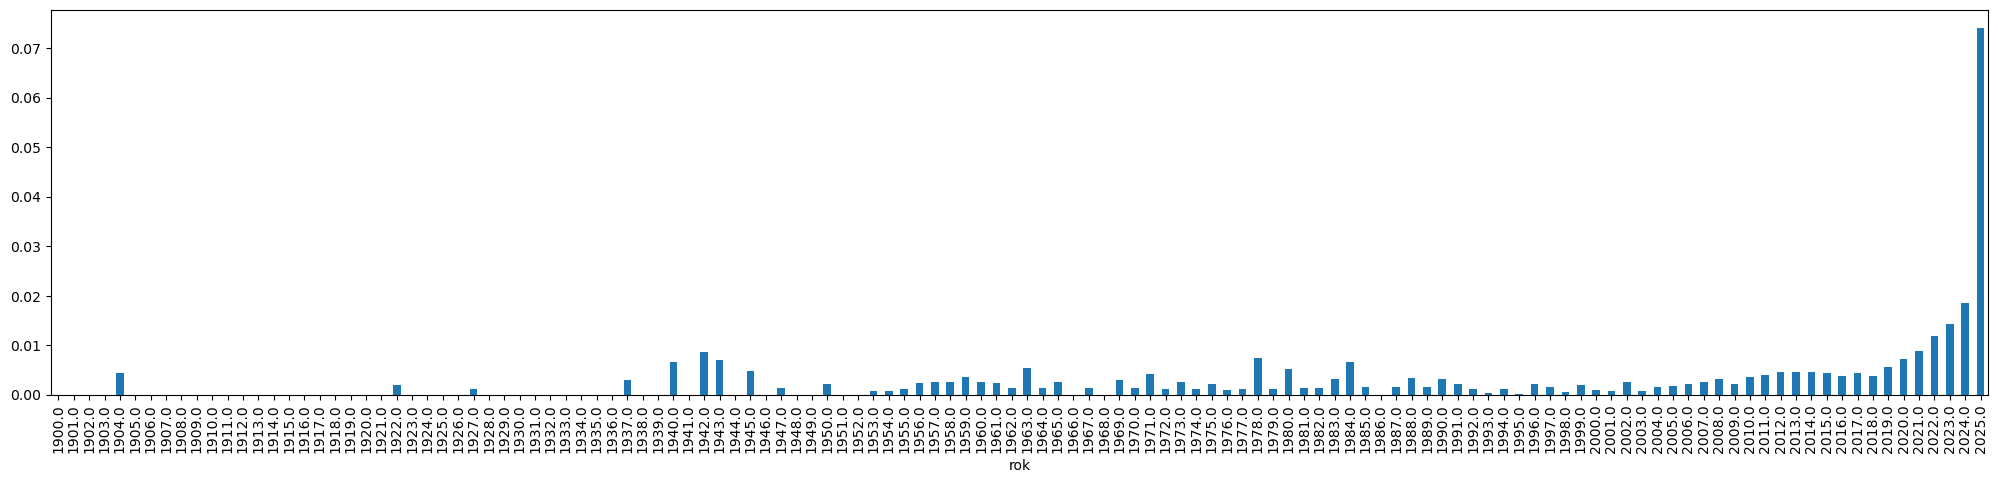

In [18]:
print(top_serie[15].name)
top_serie[15].plot.bar(figsize=(25,5))

## Variabilita / rozptyl

In [20]:
variabilita = {}
for t in top_serie:
    variabilita[t.name] = t.var()
pd.Series(variabilita).sort_values()

čínština         0.000008
nizozemština     0.000029
řečtina          0.000039
švédština        0.000041
španělština      0.000045
dánština         0.000052
madarština       0.000056
norština         0.000060
bulharština      0.000064
japonština       0.000072
latina           0.000124
italština        0.000181
polština         0.000486
slovenština      0.001371
francouzština    0.007356
němčina          0.013667
ruština          0.032479
angličtina       0.037167
dtype: float64

In [21]:
import altair as alt

In [22]:
def irozhlas():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 20,
                      'anchor': 'start',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 14,
                      'subtitlePadding': 14,
                       'dy': -14
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 11,
                "titleFontSize": 14,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 11,
                "titleFontSize": 14
            },
        }
    }

alt.themes.register('irozhlas', irozhlas)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')